# TEST 1b: 2 Separate Sinusoids Test - Equally Spaced Sampling

## Setup Dataset

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import gpytorch

# Define USER parameters for dataset
low_freq = 0.1 # Hz
high_freq = 100 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = torch.linspace(-10, 10, n_samples)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples)
y1_low_freq = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise)
y2_high_freq = torch.sin(2 * torch.pi * high_freq * x_train) + torch.Tensor(gw_noise)
y_train = torch.stack([y1_low_freq, y2_high_freq], -1)

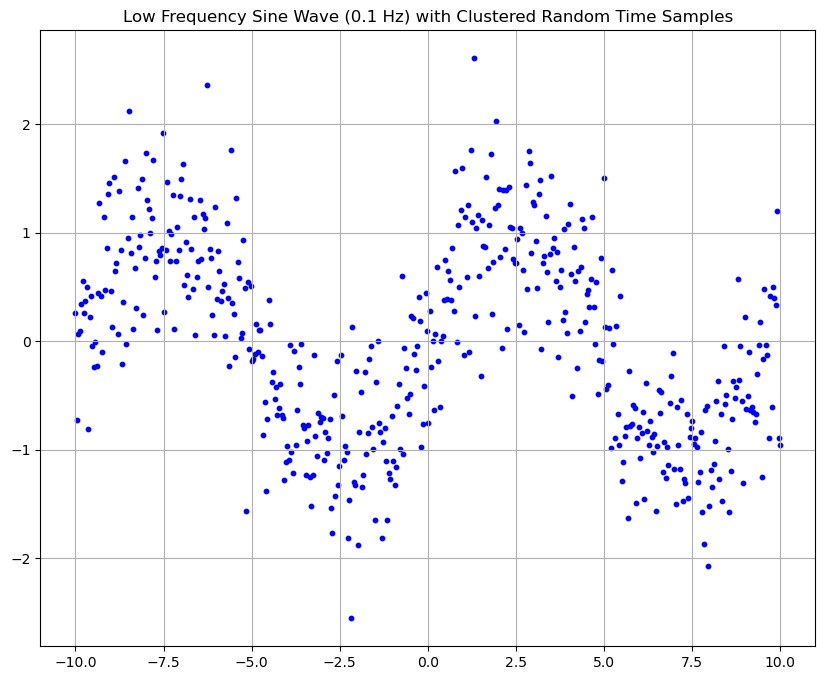

In [6]:
# Plot low frequency sine wave
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y1_low_freq, color='blue', s=10)
plt.title(f'Low Frequency Sine Wave ({low_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

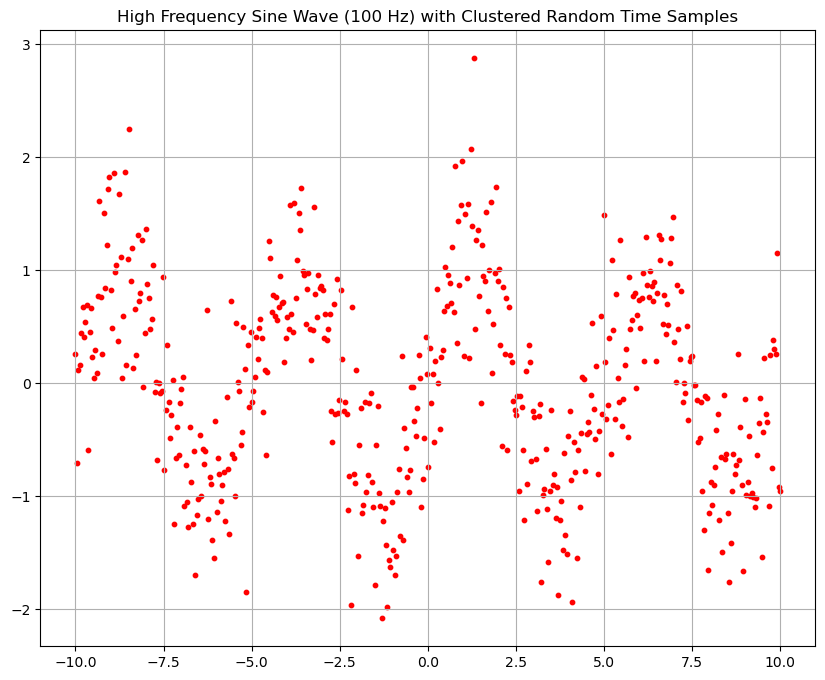

In [7]:
# Plot high frequency sine wave in a separate figure
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y2_high_freq, color='red', s=10)
plt.title(f'High Frequency Sine Wave ({high_freq} Hz) with Clustered Random Time Samples')
plt.grid(True)
plt.show()

## Train the Batch GP model

In [8]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model_sin2 = BatchIndependentMultitaskGPModel(x_train, y_train, likelihood)

# Find optimal model hyperparameters
model_sin2.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model_sin2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model_sin2)

training_epochs = 250
for i in range(training_epochs):
    optimizer.zero_grad()
    output = model_sin2(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_epochs, loss.item()))
    optimizer.step()

Iter 1/250 - Loss: 1.238
Iter 2/250 - Loss: 1.207
Iter 3/250 - Loss: 1.173
Iter 4/250 - Loss: 1.144
Iter 5/250 - Loss: 1.114
Iter 6/250 - Loss: 1.093
Iter 7/250 - Loss: 1.048
Iter 8/250 - Loss: 1.029
Iter 9/250 - Loss: 1.001
Iter 10/250 - Loss: 0.972
Iter 11/250 - Loss: 0.951
Iter 12/250 - Loss: 0.926
Iter 13/250 - Loss: 0.900
Iter 14/250 - Loss: 0.882
Iter 15/250 - Loss: 0.862
Iter 16/250 - Loss: 0.848
Iter 17/250 - Loss: 0.835
Iter 18/250 - Loss: 0.818
Iter 19/250 - Loss: 0.815
Iter 20/250 - Loss: 0.805
Iter 21/250 - Loss: 0.815
Iter 22/250 - Loss: 0.818
Iter 23/250 - Loss: 0.810
Iter 24/250 - Loss: 0.814
Iter 25/250 - Loss: 0.807
Iter 26/250 - Loss: 0.813
Iter 27/250 - Loss: 0.813
Iter 28/250 - Loss: 0.819
Iter 29/250 - Loss: 0.813
Iter 30/250 - Loss: 0.818
Iter 31/250 - Loss: 0.824
Iter 32/250 - Loss: 0.826
Iter 33/250 - Loss: 0.813
Iter 34/250 - Loss: 0.819
Iter 35/250 - Loss: 0.820
Iter 36/250 - Loss: 0.812
Iter 37/250 - Loss: 0.807
Iter 38/250 - Loss: 0.809
Iter 39/250 - Loss: 0

## Make predictions with the GP model and Plot it

In [9]:
# Set into eval mode
model_sin2.eval()
likelihood.eval()

# Make predictions
# IMP NOTE:    
# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    x_test = torch.linspace(-10, 10, 1000)
    predictions = likelihood(model_sin2(x_test))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

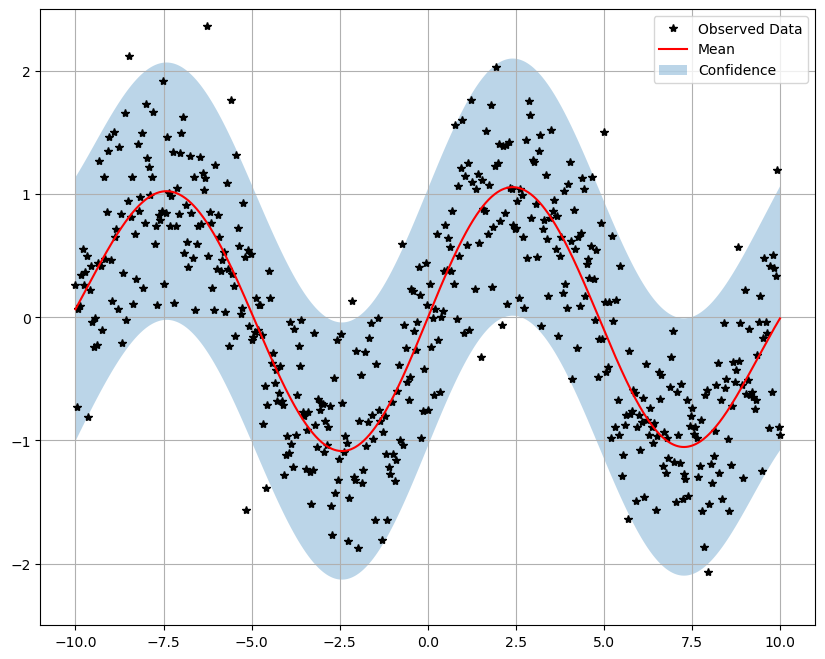

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 0].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 0].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

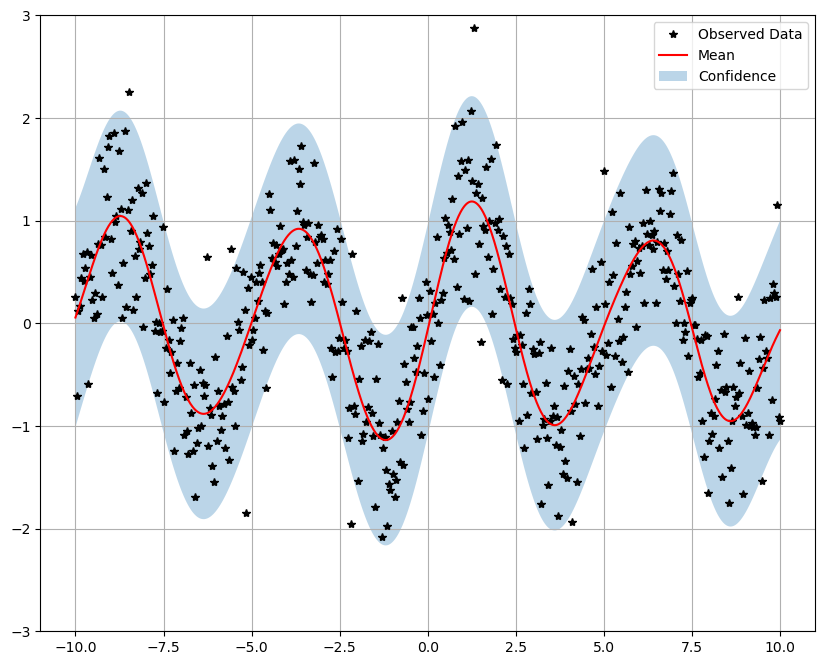

In [11]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.detach().numpy(), y_train[:, 1].detach().numpy(), 'k*')
plt.plot(x_test.numpy(), mean[:, 1].numpy(), 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.3)
plt.ylim([-3, 3])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View Model Parameters

In [12]:
for name, param in model_sin2.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Parameter value: {param}\n")

Parameter name: likelihood.raw_task_noises
Parameter value: Parameter containing:
tensor([-1.9173, -2.0267], requires_grad=True)

Parameter name: likelihood.raw_noise
Parameter value: Parameter containing:
tensor([-1.9693], requires_grad=True)

Parameter name: mean_module.raw_constant
Parameter value: Parameter containing:
tensor([-0.0746, -0.0393], requires_grad=True)

Parameter name: covar_module.raw_outputscale
Parameter value: Parameter containing:
tensor([0.5233, 0.0958], requires_grad=True)

Parameter name: covar_module.base_kernel.raw_lengthscale
Parameter value: Parameter containing:
tensor([[[2.7345]],

        [[0.9210]]], requires_grad=True)



## Define and Fit the BLR Model

In [13]:
from sklearn.linear_model import BayesianRidge
from sklearn.multioutput import MultiOutputRegressor
import numpy as np

n_order = 5 # order for polynomial features
x_test = np.linspace(-10, 10, 1000)

# Create datasets with polynomial features
x_train_blr = np.vander(x_train.numpy(), n_order + 1, increasing=True)
x_test_blr = np.vander(x_test, n_order + 1, increasing=True)
blr_model_sin2 = MultiOutputRegressor(BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True))
# blr_model_sin2.estimator.set_params(alpha_init=1.0, lambda_init=0.001) # Had no effect

# Fit the model
blr_model_sin2.fit(x_train_blr, y_train.numpy())

MultiOutputRegressor(estimator=BayesianRidge(compute_score=True,
                                             fit_intercept=False, tol=1e-06))

## Make predictions with the BLR model and Plot it

In [14]:
# NOTE: Multi-output regressor doesn't support return_std, so have to pass test data into model through a loop
# Collect the mean and standard deviation for each output
y_means = np.zeros((x_test_blr.shape[0], 2))
y_stds = np.zeros((x_test_blr.shape[0], 2))

# Pass the test data through the model
for i, model in enumerate(blr_model_sin2.estimators_):
    y_mean, y_std = model.predict(x_test_blr, return_std=True)
    y_means[:, i] = y_mean
    y_stds[:, i] = y_std

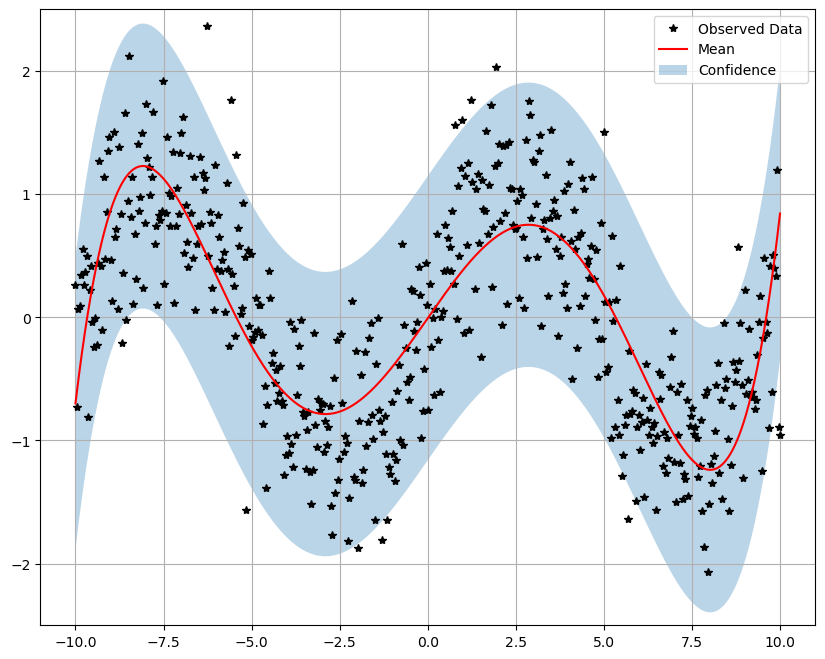

In [15]:
# Plot y1 (low freq sine wave) 
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 0].numpy(), 'k*')
plt.plot(x_test, y_means[:, 0], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 0] - 2 * y_stds[:, 0], y_means[:, 0] + 2 * y_stds[:, 0], alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

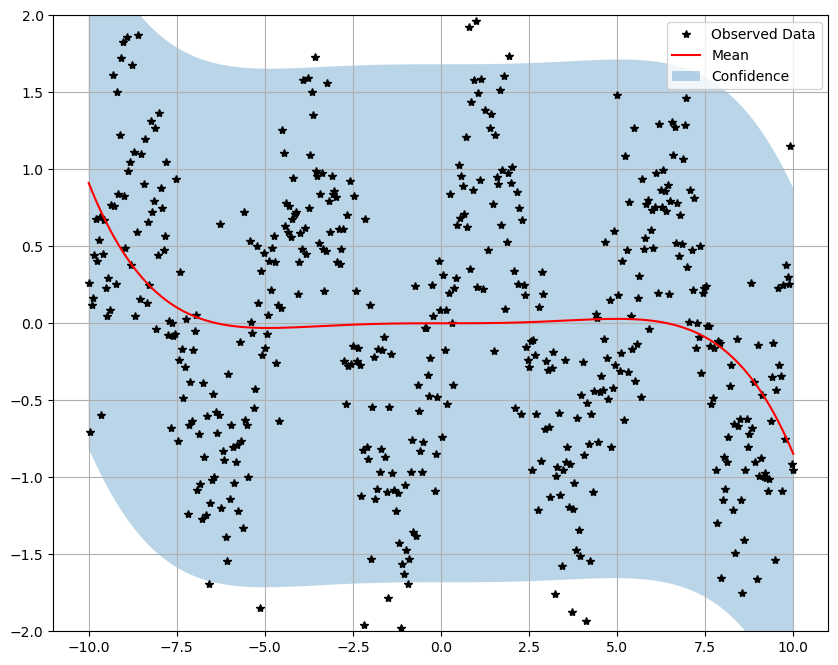

In [16]:
# Plot y2 (high freq sine wave)
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train[:, 1].numpy(), 'k*')
plt.plot(x_test, y_means[:, 1], 'r') # Predictive mean 

# Shade in confidence 
plt.fill_between(x_test, y_means[:, 1] - 2 * y_stds[:, 1], y_means[:, 1] + 2 * y_stds[:, 1], alpha=0.3)
plt.ylim([-2, 2])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## View BLR Model Parameters

In [17]:
# Pass the test data through the model
for i, model in enumerate(blr_model_sin2.estimators_):
    print(f"Model {i + 1}")
    print(f"Alpha (Estimated precision of the noise): {model.alpha_}")
    print(f"Lambda (Estimated precision of the weights): {model.lambda_}")
    print(f"Score (log marginal likelihood): {model.scores_[-1]}")

Model 1
Alpha (Estimated precision of the noise): 3.0288060548851985
Lambda (Estimated precision of the weights): 35.03263747431376
Score (log marginal likelihood): -468.8551581201314
Model 2
Alpha (Estimated precision of the noise): 1.4138181342631726
Lambda (Estimated precision of the weights): 1210347.4851276954
Score (log marginal likelihood): -634.7625685895249


## Setup Online Variational Conditioning GP Model for Low Freq Sine

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

#
# Low Freq Wave
#

# Define USER parameters for dataset
low_freq = 0.1 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = torch.linspace(-10, 10, n_samples).view(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples)
y_train = torch.sin(2 * torch.pi * low_freq * x_train) + torch.Tensor(gw_noise).view(-1, 1)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(torch.randn(25, 1), likelihood)

## Train GP Model

In [19]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

epochs = 500
for i in range(epochs + 1):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 1.77055025100708
Iteration:  50 	 Loss: 0.9412588477134705
Iteration:  100 	 Loss: 0.80391925573349
Iteration:  150 	 Loss: 0.7982859015464783
Iteration:  200 	 Loss: 0.7922480702400208
Iteration:  250 	 Loss: 0.7801477313041687
Iteration:  300 	 Loss: 0.7585659027099609
Iteration:  350 	 Loss: 0.7503542900085449
Iteration:  400 	 Loss: 0.7483073472976685
Iteration:  450 	 Loss: 0.7483652830123901
Iteration:  500 	 Loss: 0.749477207660675


## Eval GP Model

In [20]:
model.eval()
likelihood.eval()

x_test = torch.linspace(-15, 20, 250).view(-1, 1)
with torch.no_grad():
    posterior = likelihood(model(x_test))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

## Update Model with new data

In [21]:
n_test_samples = 50
new_x_train = torch.linspace(10, 20, n_test_samples).view(-1, 1)
gw_noise = np.random.normal(0, 0.5, n_test_samples)
new_y_train = torch.sin(2 * torch.pi * low_freq * new_x_train) + torch.Tensor(gw_noise).view(-1, 1)

updated_model = model.variational_strategy.get_fantasy_model(inputs=new_x_train, targets=new_y_train.squeeze())

with torch.no_grad():
    updated_posterior = updated_model.likelihood(updated_model(x_test))
    mean_updated = updated_posterior.mean
    lower_updated, upper_updated = updated_posterior.confidence_region()

/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/lancepharand/ENTER/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


## Plot GP Model for Low Freq Sine Results

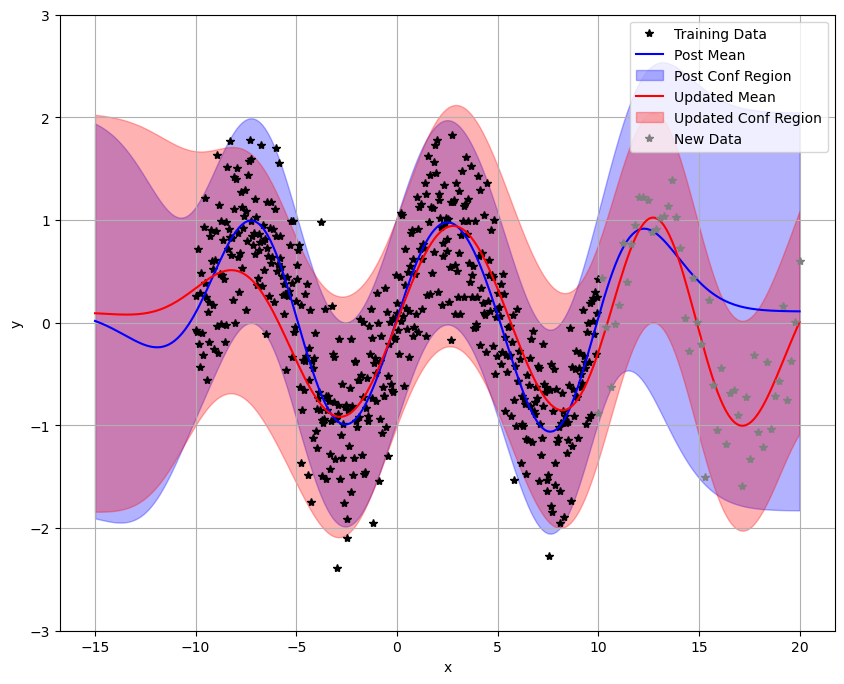

In [22]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label="Training Data") # data
plt.plot(x_test.numpy(), mean.numpy(), 'b-', label="Post Mean") # posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower.squeeze().numpy(),
                 upper.squeeze().numpy(),
                 alpha=0.3,
                 color="blue",
                 label = "Post Conf Region") # Shade in confidence

plt.plot(x_test.numpy(), mean_updated.numpy(), 'r', label="Updated Mean") # updated posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower_updated.squeeze().numpy(),
                 upper_updated.squeeze().numpy(),
                 alpha=0.3,
                 color="red",
                 label="Updated Conf Region") # Shade in confidence
plt.plot(new_x_train, new_y_train.numpy(), linestyle="None", color="gray", marker="*", label="New Data")

plt.ylim([-3, 3])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Setup Online Variational Conditioning GP Model for High Freq Sine

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

#
# High Freq Wave
#

# Define USER parameters for dataset
high_freq = 100 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = torch.linspace(-10, 10, n_samples).view(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples)
y_train = torch.sin(2 * torch.pi * high_freq * x_train) + torch.Tensor(gw_noise).view(-1, 1)

from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy

class GPModel(ApproximateGP):
    def __init__(self, inducing_points, likelihood):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        self.likelihood = likelihood

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(torch.randn(25, 1), likelihood)

## Train GP Model

In [58]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

epochs = 1000
for i in range(epochs + 1):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 1.7672463655471802
Iteration:  50 	 Loss: 1.1566269397735596
Iteration:  100 	 Loss: 1.1555118560791016
Iteration:  150 	 Loss: 1.1553699970245361
Iteration:  200 	 Loss: 1.1549570560455322
Iteration:  250 	 Loss: 1.1547092199325562
Iteration:  300 	 Loss: 1.154491901397705
Iteration:  350 	 Loss: 1.1094155311584473
Iteration:  400 	 Loss: 1.094464898109436
Iteration:  450 	 Loss: 1.0303460359573364
Iteration:  500 	 Loss: 1.020354151725769
Iteration:  550 	 Loss: 0.8668804168701172
Iteration:  600 	 Loss: 0.7951207756996155
Iteration:  650 	 Loss: 0.7896577715873718
Iteration:  700 	 Loss: 0.7773229479789734
Iteration:  750 	 Loss: 0.7514822483062744
Iteration:  800 	 Loss: 0.7484629154205322
Iteration:  850 	 Loss: 0.7470270991325378
Iteration:  900 	 Loss: 0.7459370493888855
Iteration:  950 	 Loss: 0.7456783652305603
Iteration:  1000 	 Loss: 0.7456396818161011


## Eval GP Model

In [59]:
model.eval()
likelihood.eval()

x_test = torch.linspace(-15, 20, 250).view(-1, 1)
with torch.no_grad():
    posterior = likelihood(model(x_test))
    mean = posterior.mean
    lower, upper = posterior.confidence_region()

## Update Model with new data

In [60]:
n_test_samples = 250
new_x_train = torch.linspace(10, 20, n_test_samples).view(-1, 1)
gw_noise = np.random.normal(0, 0.5, n_test_samples)
new_y_train = torch.sin(2 * torch.pi * high_freq * new_x_train) + torch.Tensor(gw_noise).view(-1, 1)

updated_model = model.variational_strategy.get_fantasy_model(inputs=new_x_train, targets=new_y_train.squeeze())

with torch.no_grad():
    updated_posterior = updated_model.likelihood(updated_model(x_test))
    mean_updated = updated_posterior.mean
    lower_updated, upper_updated = updated_posterior.confidence_region()

## Plot GP Model for High Freq Sine Results

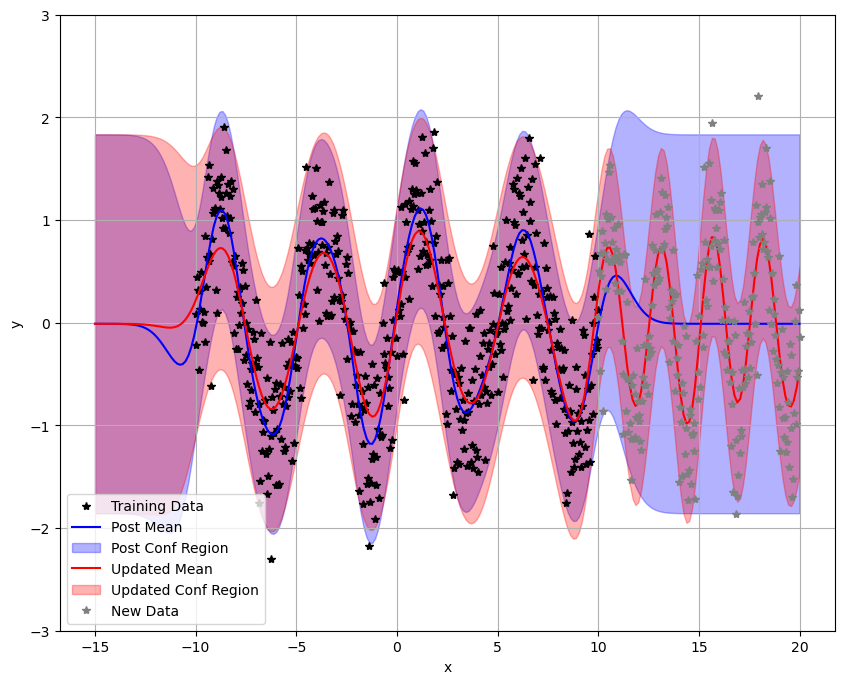

In [61]:
plt.figure(figsize=(10, 8))
plt.plot(x_train.numpy(), y_train.numpy(), 'k*', label="Training Data") # data
plt.plot(x_test.numpy(), mean.numpy(), 'b-', label="Post Mean") # posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower.squeeze().numpy(),
                 upper.squeeze().numpy(),
                 alpha=0.3,
                 color="blue",
                 label = "Post Conf Region") # Shade in confidence

plt.plot(x_test.numpy(), mean_updated.numpy(), 'r', label="Updated Mean") # updated posterior mean
plt.fill_between(x_test.squeeze().numpy(),
                 lower_updated.squeeze().numpy(),
                 upper_updated.squeeze().numpy(),
                 alpha=0.3,
                 color="red",
                 label="Updated Conf Region") # Shade in confidence
plt.plot(new_x_train, new_y_train.numpy(), linestyle="None", color="gray", marker="*", label="New Data")

plt.ylim([-3, 3])
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## Setup BLL NN for Low Freq Sine

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class BLL_NN(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU):
        super().__init__()
        layers = []
        
        # Initialize Input layer size
        in_size = architecture[0]
        
        # Add hidden layers
        for layer in range(1, len(architecture) - 1):
            out_size = architecture[layer]
            layers.append(nn.Linear(in_size, out_size))
            layers.append(activation_fn())
            in_size = out_size # for next layer 
        
        # Output layer (no activation for the output layer)
        layers.append(nn.Linear(in_size, architecture[-1]))
        
        # Create a sequential model with the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the model.
        """
        return self.network(x)
    
    def get_activations(self, x):
        """
        Method to get intermediate activations before the final output layer.
        """
        activations = []
        for layer in self.network[:-1]:  # Ignore the last output layer
            x = layer(x)
            activations.append(x)
        return activations[-1] # Return the final hidden activations
    
    def get_std(self, x_test, x_train, sig_w=1e0, sig_e=1e0):
        Sigma_E = np.eye(x_train.shape[0]) * 1 / sig_e**2          
        Sigma_W = np.eye(architecture[-2]) * 1 / sig_w**2
        
        a_train = self.get_activations(x_train)
        a_hat = self.get_activations(x_test)
        
        cov = a_hat.detach().numpy() @ np.linalg.inv(a_train.T.detach().numpy() @ Sigma_E @ a_train.detach().numpy() 
                                                     + Sigma_W) @ a_hat.T.detach().numpy()
        std2_nn_raw = np.diag(cov).reshape(x_test.shape)
        std_nn_raw = np.sqrt(std2_nn_raw)
        # err_nn_raw = np.abs(y_hat_nn.detach().numpy() - y_test).reshape(y_test.shape)
        return std_nn_raw

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the architecture and create the model
architecture = [1, 50, 50, 1]
model = BLL_NN(architecture, activation_fn=nn.Tanh)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## Setup Low Freq Sine Dataset

In [63]:
# Define USER parameters for dataset
low_freq = 0.1 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = np.linspace(-10, 10, n_samples).reshape(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples).reshape(-1, 1)
y_train = np.sin(2 * np.pi * low_freq * x_train) + gw_noise

## Train BLL NN

In [64]:
# Train model
x_train_tens = torch.Tensor(x_train)
y_train_tens = torch.Tensor(y_train)
num_epochs = 500

for epoch in range(num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train_tens)
    loss = criterion(y_pred, y_train_tens)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.8569767475128174
Epoch 10, Loss: 0.6166636943817139
Epoch 20, Loss: 0.4357602000236511
Epoch 30, Loss: 0.3656902015209198
Epoch 40, Loss: 0.35082992911338806
Epoch 50, Loss: 0.3413320481777191
Epoch 60, Loss: 0.3293764293193817
Epoch 70, Loss: 0.32307887077331543
Epoch 80, Loss: 0.3180125057697296
Epoch 90, Loss: 0.31432628631591797
Epoch 100, Loss: 0.31157734990119934
Epoch 110, Loss: 0.30944085121154785
Epoch 120, Loss: 0.30773991346359253
Epoch 130, Loss: 0.306313693523407
Epoch 140, Loss: 0.3050656020641327
Epoch 150, Loss: 0.3039191961288452
Epoch 160, Loss: 0.30281880497932434
Epoch 170, Loss: 0.30173105001449585
Epoch 180, Loss: 0.30063164234161377
Epoch 190, Loss: 0.2994579076766968
Epoch 200, Loss: 0.2981429696083069
Epoch 210, Loss: 0.2966439127922058
Epoch 220, Loss: 0.2949589490890503
Epoch 230, Loss: 0.293074369430542
Epoch 240, Loss: 0.2913454473018646
Epoch 250, Loss: 0.2889907956123352
Epoch 260, Loss: 0.28694161772727966
Epoch 270, Loss: 0.284735798835

## Obtain BLL Predictions

In [65]:
# Setup Test Data
n_test_samples = n_samples * 2
x_test = np.linspace(-15, 15, n_test_samples).reshape(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_test_samples).reshape(-1, 1)
y_test = np.sin(2 * np.pi * low_freq * x_test) + gw_noise

# Eval test data
x_test_tens = torch.Tensor(x_test)

model.eval()
with torch.no_grad():
    y_hat_nn = model(x_test_tens)

std_nn = model.get_std(x_test_tens, x_train_tens)

## Plot BLL Predictions for Low Freq Sine

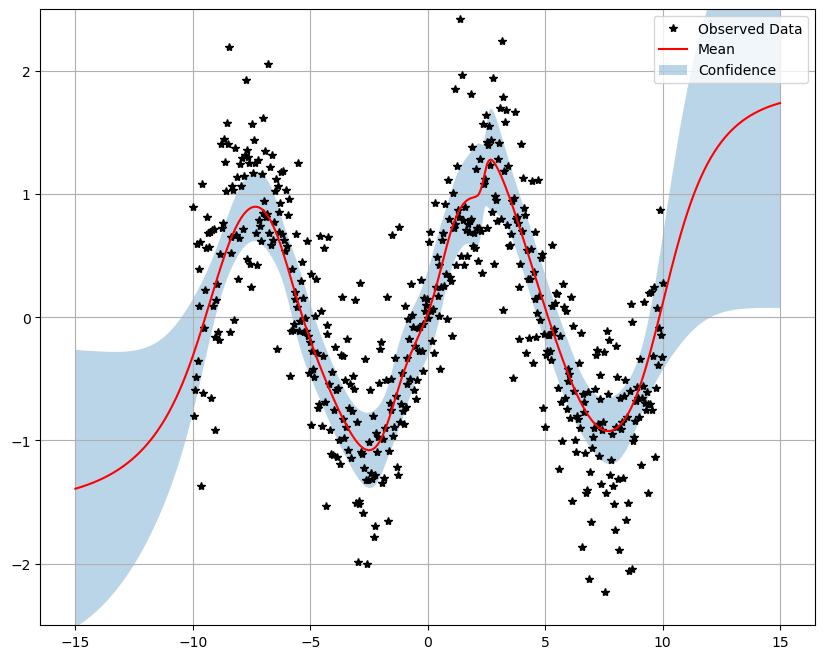

In [66]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*')
plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 

lower = y_hat_nn.detach().numpy() - 2 * std_nn
upper = y_hat_nn.detach().numpy() + 2 * std_nn

# Shade in confidence 
plt.fill_between(x_test.squeeze(), 
                 lower.squeeze(), 
                 upper.squeeze(), 
                 alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## Setup BLL NN for High Freq Sine

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


class BLL_NN(nn.Module):
    def __init__(self, architecture, activation_fn=nn.ReLU):
        super().__init__()
        layers = []
        
        # Initialize Input layer size
        in_size = architecture[0]
        
        # Add hidden layers
        for layer in range(1, len(architecture) - 1):
            out_size = architecture[layer]
            layers.append(nn.Linear(in_size, out_size))
            layers.append(activation_fn())
            in_size = out_size # for next layer 
        
        # Output layer (no activation for the output layer)
        layers.append(nn.Linear(in_size, architecture[-1]))
        
        # Create a sequential model with the layers
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        """
        Forward pass through the model.
        """
        return self.network(x)
    
    def get_activations(self, x):
        """
        Method to get intermediate activations before the final output layer.
        """
        activations = []
        for layer in self.network[:-1]:  # Ignore the last output layer
            x = layer(x)
            activations.append(x)
        return activations[-1] # Return the final hidden activations
    
    def get_std(self, x_test, x_train, sig_w=1e0, sig_e=1e0):
        Sigma_E = np.eye(x_train.shape[0]) * 1 / sig_e**2          
        Sigma_W = np.eye(architecture[-2]) * 1 / sig_w**2
        
        a_train = self.get_activations(x_train)
        a_hat = self.get_activations(x_test)
        
        cov = a_hat.detach().numpy() @ np.linalg.inv(a_train.T.detach().numpy() @ Sigma_E @ a_train.detach().numpy() 
                                                     + Sigma_W) @ a_hat.T.detach().numpy()
        std2_nn_raw = np.diag(cov).reshape(x_test.shape)
        std_nn_raw = np.sqrt(std2_nn_raw)
        # err_nn_raw = np.abs(y_hat_nn.detach().numpy() - y_test).reshape(y_test.shape)
        return std_nn_raw

# Set random seed for reproducibility
torch.manual_seed(42)

# Define the architecture and create the model
architecture = [1, 50, 50, 1]
model = BLL_NN(architecture, activation_fn=nn.Tanh)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

## Setup High Freq Sine Dataset

In [68]:
# Define USER parameters for dataset
high_freq = 100 # Hz
n_samples = 500

# Setup equally spaced input data
x_train = np.linspace(-10, 10, n_samples).reshape(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_samples).reshape(-1, 1)
y_train = np.sin(2 * np.pi * high_freq * x_train) + gw_noise

## Train BLL NN

In [69]:
# Train model
x_train_tens = torch.Tensor(x_train)
y_train_tens = torch.Tensor(y_train)
num_epochs = 500

for epoch in range(num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    y_pred = model(x_train_tens)
    loss = criterion(y_pred, y_train_tens)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.7302280068397522
Epoch 10, Loss: 0.8338548541069031
Epoch 20, Loss: 0.6834032535552979
Epoch 30, Loss: 0.6316646933555603
Epoch 40, Loss: 0.6156396865844727
Epoch 50, Loss: 0.6040368676185608
Epoch 60, Loss: 0.5898892283439636
Epoch 70, Loss: 0.5809175372123718
Epoch 80, Loss: 0.573432207107544
Epoch 90, Loss: 0.5668734908103943
Epoch 100, Loss: 0.560636579990387
Epoch 110, Loss: 0.5539069771766663
Epoch 120, Loss: 0.545566976070404
Epoch 130, Loss: 0.5353556275367737
Epoch 140, Loss: 0.5221579074859619
Epoch 150, Loss: 0.5042308568954468
Epoch 160, Loss: 0.47678741812705994
Epoch 170, Loss: 0.43306317925453186
Epoch 180, Loss: 0.4321781098842621
Epoch 190, Loss: 0.3804651200771332
Epoch 200, Loss: 0.34192392230033875
Epoch 210, Loss: 0.32688555121421814
Epoch 220, Loss: 0.311114102602005
Epoch 230, Loss: 0.30090582370758057
Epoch 240, Loss: 0.2974269986152649
Epoch 250, Loss: 0.28794729709625244
Epoch 260, Loss: 0.28433555364608765
Epoch 270, Loss: 0.2784889340400696


## Obtain BLL Predictions

In [70]:
# Setup Test Data
n_test_samples = n_samples * 2
x_test = np.linspace(-15, 15, n_test_samples).reshape(-1, 1)

# Define function and Gaussian white noise
gw_noise = np.random.normal(0, 0.5, n_test_samples).reshape(-1, 1)
y_test = np.sin(2 * np.pi * high_freq * x_test) + gw_noise

# Eval test data
x_test_tens = torch.Tensor(x_test)

model.eval()
with torch.no_grad():
    y_hat_nn = model(x_test_tens)

std_nn = model.get_std(x_test_tens, x_train_tens)

## Plot BLL Predictions for High Freq Sine

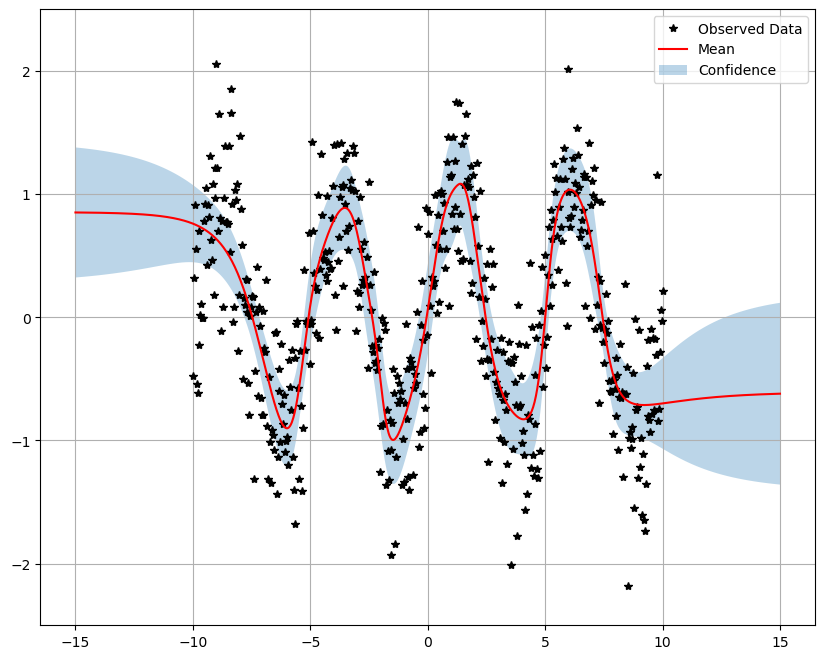

In [72]:
plt.figure(figsize=(10, 8))
plt.plot(x_train, y_train, 'k*')
plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 

lower = y_hat_nn.detach().numpy() - 2 * std_nn
upper = y_hat_nn.detach().numpy() + 2 * std_nn

# Shade in confidence 
plt.fill_between(x_test.squeeze(), 
                 lower.squeeze(), 
                 upper.squeeze(), 
                 alpha=0.3)
plt.ylim([-2.5, 2.5])
plt.legend(['Observed Data', 'Mean', 'Confidence'])
plt.grid(True)
plt.show()

## [DOESN'T WORK YET] Update Model with New Data

In [ ]:
# # Load both model and optimizer state
# checkpoint = torch.load('model_and_optimizer.pth')
# updated_model = BLL_NN(architecture, activation_fn=nn.Tanh)
# updated_model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# # optimizer = optim.Adam(updated_model.parameters(), lr=0.001)  # Start with a slightly higher value
# 
# # Setup New Data for transfer learning
# n_new_samples = 50
# x_new = np.linspace(10, 15, n_new_samples).reshape(-1, 1)
# 
# # Define function and Gaussian white noise
# gw_noise = np.random.normal(0, 0.5, n_new_samples).reshape(-1, 1)
# y_new = np.sin(2 * np.pi * high_freq * x_new) + gw_noise
# 
# x_new_tens = torch.Tensor(x_new)
# y_new_tens = torch.Tensor(y_new)
# 
# # Continue training
# num_epochs = 100
# for epoch in range(num_epochs + 1):
#     updated_model.train()
#     optimizer.zero_grad()
#     
#     # Forward pass
#     y_pred = updated_model(x_new_tens)
#     loss = criterion(y_pred, y_new_tens)
#     
#     # Backward pass and optimization
#     loss.backward()
#     optimizer.step()
#     
#     if epoch % 10 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item()}")


# # Eval updated model 
# updated_model.eval()
# with torch.no_grad():
#     y_hat_nn = updated_model(x_test_tens)
# std_nn = updated_model.get_std(x_test_tens, x_train_tens)
# 
# # Plot results of updated model
# plt.figure(figsize=(10, 8))
# plt.plot(x_train, y_train, 'k*')
# plt.plot(x_test, y_hat_nn.detach().numpy(), 'r') # Predictive mean 
# plt.plot(x_new, y_new, linestyle="None", color="gray", marker="*", label="New Data")
# 
# lower = y_hat_nn.detach().numpy() - 2 * std_nn
# upper = y_hat_nn.detach().numpy() + 2 * std_nn
# 
# # Shade in confidence 
# plt.fill_between(x_test.squeeze(), 
#                  lower.squeeze(), 
#                  upper.squeeze(), 
#                  alpha=0.3)
# plt.ylim([-2.5, 2.5])
# plt.legend(['Observed Data', 'Mean', 'Confidence'])
# plt.grid(True)
# plt.show()